# Imports

In [1]:
#Ticker Codes
from nsetools import Nse
# Raw Package
import numpy as np
import pandas as pd
#Data Source
import yfinance as yf
#Data viz
import plotly.graph_objs as go
#pywidget
import ipywidgets as widget
from IPython.display import display
import talib
import trendln
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import mplfinance as mpf
import datetime
import time

# from helper_functions import get_user_inputs, create_top_line, create_bottom_line, pull_price_data, plot_graph, isSupport, isResistance, isFarFromLevel, finding_signals_from_data, is_consolidating, is_breaking_out, technical_scoring_function, long_term_trend_scoring_function
from helper_functions import *
import helper_functions
import importlib
importlib.reload(helper_functions)
%matplotlib inline

# Functions

In [2]:
# get technical_score_df from technical_scoring_function
#Test this function with only one ticker. Should return data. 

In [3]:
# print('Select company name from drop down')
# nse = Nse()
# company_dict = nse.get_stock_codes()
# stock_ticker = widget.Dropdown(options=list(company_dict.values())[1:], value=  '20 Microns Limited', description='Stock:')
# stock_ticker

In [4]:
# zxdf

In [5]:
# pro

In [14]:
# perpro

In [15]:
# zxdf, pro, perpro = backtest_function(mode = "ACC.NS",live = 'yes')

In [17]:
#Backtesting function
def backtest_function(mode = 'all', period = -2, live = 'no', csv_file = 'n50.csv', cur_thresh = 5):
    tpm = 3 
    if(mode == 'all'):
        n50 = pd.read_csv(csv_file)
        nifty50 = []
        for t in n50['Symbol'].values:
            nifty50.append(t+'.NS')
        for t in nifty50:
            ticker = t
            #print(live)
            data = pull_price_data(live, t, mode = 'scoring')
            if(live == 'no'):
                data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 1)
            else:
                data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = tpm)
            data = plot_graph(data, g_type, plot_sup_res, mode = 'scoring')
            
            technical_score_column_list = []
            for col in data.columns:
                if(col.startswith('final_score_technical')):
                    technical_score_column_list.append(col)

            backtest_df = data.copy()
            long_profit_loss_calculation_df = pd.DataFrame(columns = ['Buy Date', 'Buy Price', 'Buy Signal', 
                                                                      'isDone', 'Sell Date', 'Sell Price',
                                                                      'Stop Loss', 'Target', 'Profit Percentage'])
            if(live == 'yes'):
                technical_score_column_list.remove('final_score_technical_DOJI-')
                technical_score_column_list.remove('final_score_technical_DOJI+')
            period = 2
            for i in range(0 , len(data) - 1, 1):
                #Dropping doji for live data
                #if(live=='yes'):
                #    backtest_df.drop(columns = ['final_score_technical_DOJI-', 'final_score_technical_DOJI+'], inplace = True)

                #df of 2 days to match techincal scoring function      
                two_day_score = backtest_df.iloc[i:i+2]

                # Adjusting score for volume
                if(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) > 0):
                    if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
                        current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) + 1
                    else:
                        current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
                elif(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) < 0):
                    if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
                        current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) - 1
                    else:
                        current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
                current_market_price = two_day_score['Adj Close'].iloc[-1]
                current_date = two_day_score.index[-1]
                if(live == 'yes'):
                    stop_loss_multiplier = 0.995
                    target_multiplier = 1.01
                else:
                    stop_loss_multiplier = 0.95
                    target_multiplier = 1.1
                if(current_score >= cur_thresh):
                    temp_row = {"Buy Date": current_date, "Buy Price": current_market_price, "Buy Signal" : current_score, 
                                "isDone" : 0, "Stop Loss": current_market_price * stop_loss_multiplier, 
                                "Target" : current_market_price * target_multiplier, "Threshold" : cur_thresh,
                               "ticker" : t}
                    long_profit_loss_calculation_df = long_profit_loss_calculation_df.append(temp_row, ignore_index = True)

                #Checking if price is above or below SL. Target
                if(len(long_profit_loss_calculation_df) > 0):
                    to_be_checked_df = long_profit_loss_calculation_df[long_profit_loss_calculation_df['isDone'] == 0]
                    for j in (to_be_checked_df.index):

                        if(to_be_checked_df.loc[j]['Target'] < current_market_price):
                            long_profit_loss_calculation_df.loc[j,"isDone"] = 1
                            long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
                            long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
                            long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100
                        elif(to_be_checked_df.loc[j]['Stop Loss'] > current_market_price):
                            long_profit_loss_calculation_df.loc[j,"isDone"] = -1
                            long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
                            long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
                            long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100
            break
        
        overall_profit = long_profit_loss_calculation_df['Profit Percentage'].sum()
        good_calls = (len(long_profit_loss_calculation_df[long_profit_loss_calculation_df['Profit Percentage'] > 0]) - len(long_profit_loss_calculation_df[long_profit_loss_calculation_df['Profit Percentage'] < 0]))/len(long_profit_loss_calculation_df)
        return(long_profit_loss_calculation_df, overall_profit, good_calls)
    else:
        print("else")
        ticker = t = mode
        data = pull_price_data(live, t, mode = 'scoring')
        if(live == 'no'):
            data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 1)
        else:
            data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = tpm)
        data = plot_graph(data, g_type, mode = 'scoring')

        technical_score_column_list = []
        for col in data.columns:
            if(col.startswith('final_score_technical')):
                technical_score_column_list.append(col)

        backtest_df = data.copy()
        long_profit_loss_calculation_df = pd.DataFrame(columns = ['Buy Date', 'Buy Price', 'Buy Signal', 
                                                                  'isDone', 'Sell Date', 'Sell Price',
                                                                  'Stop Loss', 'Target', 'Profit Percentage'])
        #print(long_profit_loss_calculation_df)
        if(live == 'yes'):
            technical_score_column_list.remove('final_score_technical_DOJI-')
            technical_score_column_list.remove('final_score_technical_DOJI+')
        period = 2
        for i in range(0 , len(data) - 1, 1):
            #Dropping doji for live data
            #if(live=='yes'):
            #    backtest_df.drop(columns = ['final_score_technical_DOJI-', 'final_score_technical_DOJI+'], inplace = True)

            #df of 2 days to match techincal scoring function      
            two_day_score = backtest_df.iloc[i:i+2]

            # Adjusting score for volume
            if(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) > 0):
                if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
                    current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) + 1
                else:
                    current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
            elif(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) < 0):
                if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
                    current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) - 1
                else:
                    current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
            current_market_price = two_day_score['Adj Close'].iloc[-1]
            current_date = two_day_score.index[-1]
            if(live == 'yes'):
                stop_loss_multiplier = 0.995
                target_multiplier = 1.01
            else:
                stop_loss_multiplier = 0.95
                target_multiplier = 1.1
            if(current_score >= cur_thresh):
                temp_row = {"Buy Date": current_date, "Buy Price": current_market_price, "Buy Signal" : current_score, 
                            "isDone" : 0, "Stop Loss": current_market_price * stop_loss_multiplier, 
                            "Target" : current_market_price * target_multiplier, "Threshold" : cur_thresh,
                           "ticker" : t}
                long_profit_loss_calculation_df = long_profit_loss_calculation_df.append(temp_row, ignore_index = True)

            #Checking if price is above or below SL. Target
            if(len(long_profit_loss_calculation_df) > 0):
                to_be_checked_df = long_profit_loss_calculation_df[long_profit_loss_calculation_df['isDone'] == 0]
                for j in (to_be_checked_df.index):

                    if(to_be_checked_df.loc[j]['Target'] < current_market_price):
                        long_profit_loss_calculation_df.loc[j,"isDone"] = 1
                        long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
                        long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
                        long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100
                    elif(to_be_checked_df.loc[j]['Stop Loss'] > current_market_price):
                        long_profit_loss_calculation_df.loc[j,"isDone"] = -1
                        long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
                        long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
                        long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100
            
        #print(len(long_profit_loss_calculation_df))
        #print(long_profit_loss_calculation_df)
        overall_profit = long_profit_loss_calculation_df['Profit Percentage'].sum()
        good_calls = (len(long_profit_loss_calculation_df[long_profit_loss_calculation_df['Profit Percentage'] > 0]) - len(long_profit_loss_calculation_df[long_profit_loss_calculation_df['Profit Percentage'] < 0]))/len(long_profit_loss_calculation_df)
    return(long_profit_loss_calculation_df, overall_profit, good_calls)

# #Getting data for single stock
# live, g_type = get_user_inputs()
# data = pull_price_data(live, stock_ticker = 'TATAMOTORS.NS')
# print(data.index[-1])

# if(live == 'yes'):
#     print("Is Consolidating: ",is_consolidating(data, percentage=0.5))
# else:
#     print("Is Consolidating: ",is_consolidating(data))

    
# if(live == 'yes'):
#     print("Is Breaking Out: ",is_breaking_out(data, percentage=2))
# else:
#     print("Is Breaking Out: ",is_breaking_out(data))    

# if(live == 'no' or live == 'max'):
#     data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 1)
# else:
#     data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 3)
# #print(levels)
# data = data[data['Close'].notna()]
# #plot_graph(data, g_type='line', mode = 'quick')
# data = plot_graph(data, g_type, mode = 'scoring')




# if(live == 'yes'):
#     technical_score_column_list.remove('final_score_technical_DOJI-')
#     technical_score_column_list.remove('final_score_technical_DOJI+')

# cur_thresh = 5
# period = 2
# for i in range(0 , len(data) - 1, 1):
#     #Dropping doji for live data
#     #if(live=='yes'):
#     #    backtest_df.drop(columns = ['final_score_technical_DOJI-', 'final_score_technical_DOJI+'], inplace = True)
        
#     #df of 2 days to match techincal scoring function      
#     two_day_score = backtest_df.iloc[i:i+2]
    
#     # Adjusting score for volume
#     if(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) > 0):
#         if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
#             current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) + 1
#         else:
#             current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
#     elif(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) < 0):
#         if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
#             current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) - 1
#         else:
#             current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
#     current_market_price = two_day_score['Adj Close'].iloc[-1]
#     current_date = two_day_score.index[-1]
#     if(live == 'yes'):
#         stop_loss_multiplier = 0.997
#         target_multiplier = 1.008
#     else:
#         stop_loss_multiplier = 0.97
#         target_multiplier = 1.5
#     if(current_score >= cur_thresh):
#         temp_row = {"Buy Date": current_date, "Buy Price": current_market_price, "Buy Signal" : current_score, 
#                     "isDone" : 0, "Stop Loss": current_market_price * stop_loss_multiplier, 
#                     "Target" : current_market_price * target_multiplier, "Threshold" : cur_thresh,
#                    "ticker" : backtest_ticker}
#         long_profit_loss_calculation_df = long_profit_loss_calculation_df.append(temp_row, ignore_index = True)
    
#     #Checking if price is above or below SL. Target
#     if(len(long_profit_loss_calculation_df) > 0):
#         to_be_checked_df = long_profit_loss_calculation_df[long_profit_loss_calculation_df['isDone'] == 0]
#         for j in (to_be_checked_df.index):
            
#             if(to_be_checked_df.loc[j]['Target'] < current_market_price):
#                 long_profit_loss_calculation_df.loc[j,"isDone"] = 1
#                 long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
#                 long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
#                 long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100
#             elif(to_be_checked_df.loc[j]['Stop Loss'] > current_market_price):
#                 long_profit_loss_calculation_df.loc[j,"isDone"] = -1
#                 long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
#                 long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
#                 long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100

# Running functions

Do you want live data?: yes/ no/ max
no
Enter period of months6
Enter interval(1m, 1d, 1wk)1d
[*********************100%***********************]  1 of 1 completed
2022-07-15 00:00:00
Is Consolidating:  False
Is Breaking Out:  False
[(6, 410.70001220703125), (10, 392.0), (24, 319.1000061035156), (27, 344.0), (52, 333.0), (104, 305.0)]


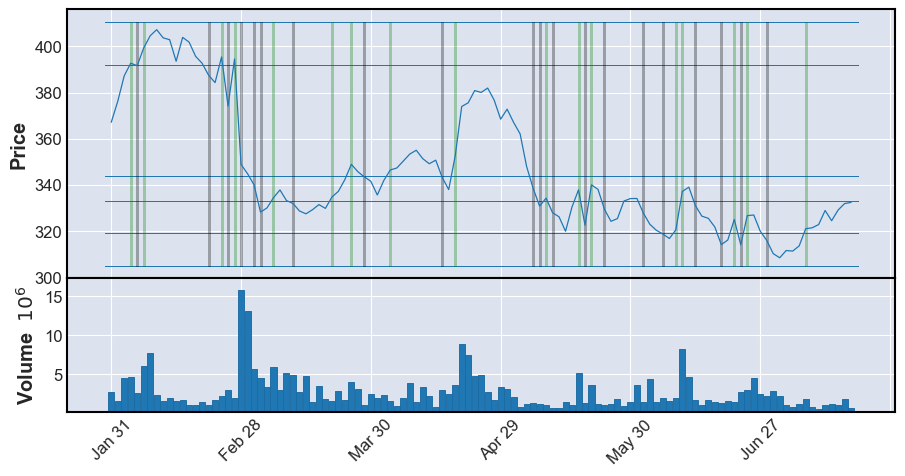

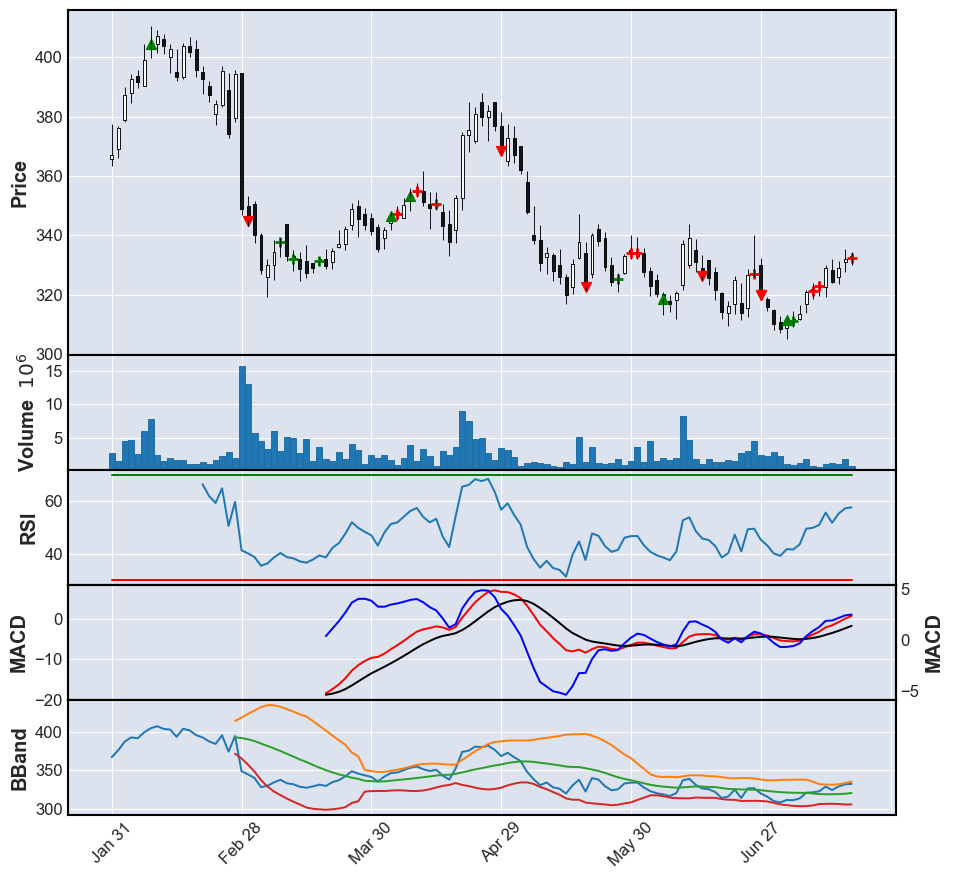

In [19]:
#Getting data for single stock
live, g_type = get_user_inputs()
data = pull_price_data(live, stock_ticker = 'BIOCON.NS')
print(data.index[-1])

if(live == 'yes'):
    print("Is Consolidating: ",is_consolidating(data, percentage=0.5))
else:
    print("Is Consolidating: ",is_consolidating(data))

    
if(live == 'yes'):
    print("Is Breaking Out: ",is_breaking_out(data, percentage=2))
else:
    print("Is Breaking Out: ",is_breaking_out(data))    

if(live == 'no' or live == 'max'):
    data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 1)
else:
    data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 3)
print(levels)
data = data[data['Close'].notna()]
plot_graph(data, g_type='line', mode = 'quick', plot_sup_res = plot_sup_res)
data = plot_graph(data, g_type, plot_sup_res = plot_sup_res)

In [18]:
a, b = technical_scoring_function(mode = 'INTC', live = 'no')
a

[*********************100%***********************]  1 of 1 completed


,final_score_technical_Volume,final_score_technical__RSI+,final_score_technical__RSI-,final_score_technical_MACD+,final_score_technical_MACD-,final_score_technical_BB+,final_score_technical_BB-,final_score_technical_supres+,final_score_technical_supres-,final_score_technical_CDL3INSIDE-,...,final_score_technical_CDLSEPARATINGLINES-,final_score_technical_CDL3INSIDE+,final_score_technical_CDL3OUTSIDE+,final_score_technical_CDLHAMMER+,final_score_technical_CDLINVERTEDHAMMER+,final_score_technical_CDLMORNINGSTAR+,final_score_technical_CDLSEPARATINGLINES+,final_score_technical_CDLUNIQUE3RIVER+,final_score_technical_DOJI-,final_score_technical_DOJI+
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-14,1.0,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# All scoring function

In [19]:
#Scoring function (Gives Signal of Reversal)
# personal list = ['BIOCON.NS','COLPAL.NS']
start = datetime.datetime.now()
print(datetime.datetime.now())

pos_score_company, neg_score_company = technical_scoring_function(live = 'no', csv_file = 'n50.csv') #live, period, ticker as params
print('All Done')

pos_score_company = sorted(pos_score_company.items(), key=lambda x: x[1], reverse = True)
#neg_score_company = sorted(neg_score_company.items(), key=lambda x: x[1])


print(pos_score_company,'\n\n\n')
#print(neg_score_company)
print(datetime.datetime.now() - start)

2022-07-16 14:45:07.661087
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[******

In [20]:
#Scoring function (Gives Longterm Trend)
print(datetime.datetime.now())

long_neg_score_company, long_pos_score_company = long_term_trend_scoring_function(live = 'no', csv_file = 'n50.csv') #live, period, ticker as params
print('All Done')

long_pos_score_company = sorted(long_pos_score_company.items(), key=lambda x: x[1], reverse = True)
long_neg_score_company = sorted(long_neg_score_company.items(), key=lambda x: x[1])


print(long_pos_score_company,'\n\n\n')
print(long_neg_score_company)



2022-07-16 14:46:02.522596
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[******

# My list

In [35]:
#Scoring function (Gives Signal of Reversal)
# personal list = ['BIOCON.NS','COLPAL.NS']
pos_score_company, neg_score_company = technical_scoring_function(mode = "list") #live, period, ticker as params
print('All Done')

pos_score_company = sorted(pos_score_company.items(), key=lambda x: x[1], reverse = True)
neg_score_company = sorted(neg_score_company.items(), key=lambda x: x[1])


print(pos_score_company,'\n\n\n')
print(neg_score_company)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
All Done
[('BIOCON.NS', 0.0), ('COLPAL.NS', 0.0)] 



[]


In [36]:
#Scoring function (Gives Longterm Trend)
neg_score_company, pos_score_company = long_term_trend_scoring_function(mode = 'list') #live, period, ticker as params
print('All Done')

pos_score_company = sorted(pos_score_company.items(), key=lambda x: x[1], reverse = True)
neg_score_company = sorted(neg_score_company.items(), key=lambda x: x[1])


print(pos_score_company,'\n\n\n')
print(neg_score_company)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
All Done
[] 



[('BIOCON.NS', -0.5), ('COLPAL.NS', 4.5)]


### Loops for continuous running for live data

In [25]:
def update():
    import time
    from IPython.display import clear_output
    while True:
        pos_score_company, neg_score_company = technical_scoring_function( live = 'yes', csv_file = 'n50.csv') #live, period, ticker as params
        #pos_score_company = sorted(pos_score_company.items(), key=lambda x: x[1], reverse = True)
        #neg_score_company = sorted(neg_score_company.items(), key=lambda x: x[1])

        #clear_output(wait=True)
        print(pos_score_company, datetime.datetime.now().strftime("%H:%M:%S"))
        #print(neg_score_company)
        time.sleep(29)

update()

[*********************100%***********************]  1 of 1 completed
Error with ACC.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Error with APOLLOHOSP.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 c

KeyboardInterrupt: 

In [38]:
# 
def update():
    import time
    from IPython.display import clear_output
    while True:
        pos_score_company, neg_score_company = long_term_trend_scoring_function(mode = "list", live = 'yes') #live, period, ticker as params
        #pos_score_company = sorted(pos_score_company.items(), key=lambda x: x[1], reverse = True)
        #neg_score_company = sorted(neg_score_company.items(), key=lambda x: x[1])

        #clear_output(wait=True)
        print(pos_score_company, datetime.datetime.now().strftime("%H:%M:%S"))
        #print(neg_score_company)
        time.sleep(3)

update()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'BIOCON.NS': 1.5, 'COLPAL.NS': 9.0} 14:53:46
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'BIOCON.NS': 1.5, 'COLPAL.NS': 9.0} 14:53:51
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'BIOCON.NS': 1.5, 'COLPAL.NS': 9.0} 14:53:55
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'BIOCON.NS': 1.5, 'COLPAL.NS': 9.0} 14:54:00
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
{'BIOCON.NS': 1.5, 'COLPAL.NS': 9.0} 14:54:05


KeyboardInterrupt: 

# Backtesting

Enter period of months12
Enter interval(1m, 1d, 1wk)1d
[*********************100%***********************]  1 of 1 completed
2022-07-15 00:00:00


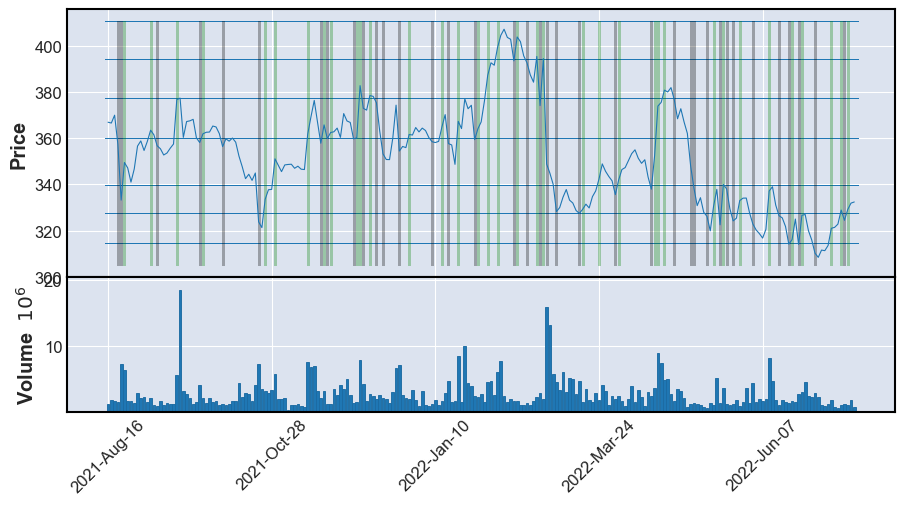

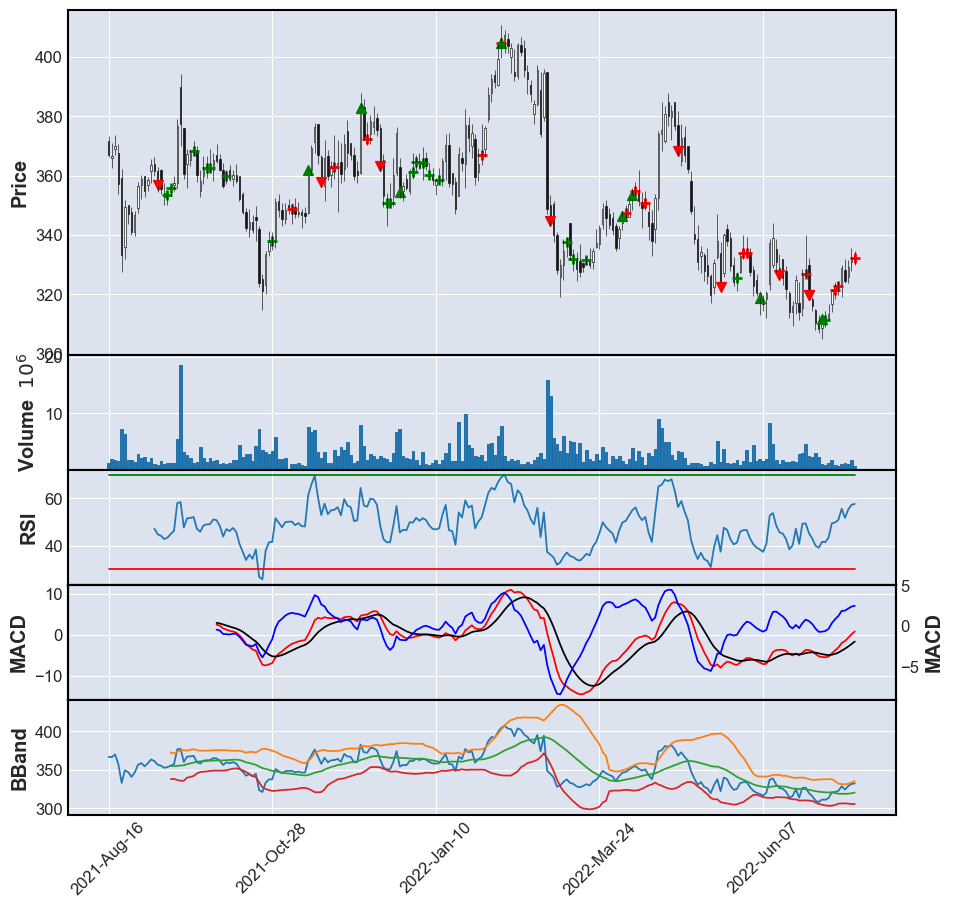

Positive Signal
 DatetimeIndex(['2021-12-08', '2022-06-09', '2022-06-23', '2022-07-06'], dtype='datetime64[ns]', name='Date', freq=None) Date
2021-12-08    6.5
2022-06-09    4.5
2022-06-23    4.5
2022-07-06    4.5
dtype: float64


Negative Signal DatetimeIndex(['2021-12-06', '2022-02-18', '2022-05-06', '2022-06-17',
               '2022-06-22', '2022-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None) Date
2021-12-06   -4.5
2022-02-18   -4.0
2022-05-06   -4.5
2022-06-17   -4.0
2022-06-22   -4.0
2022-06-29   -4.0
dtype: float64


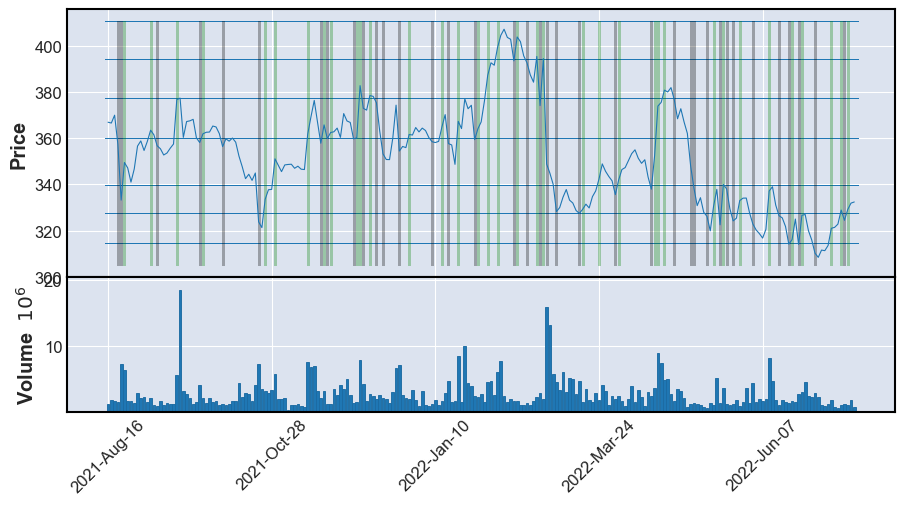

,Open,High,Low,Close,Adj Close,Volume,y0,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,...,final_score_technical_CDLEVENINGSTAR-,final_score_technical_CDL3INSIDE+,final_score_technical_CDL3OUTSIDE+,final_score_technical_CDLHAMMER+,final_score_technical_CDLSEPARATINGLINES+,final_score_technical_CDLXSIDEGAP3METHODS+,final_score_technical_DOJI-,final_score_technical_DOJI+,graph_DOJI-,graph_DOJI+
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-16,371.750000,373.250000,366.200012,366.950012,366.358521,1228973,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-17,366.049988,371.000000,362.649994,366.600006,366.009094,1875933,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-18,368.899994,373.700012,367.049988,370.000000,369.403595,1733630,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-20,367.700012,370.799988,353.899994,357.350006,356.773987,1544686,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-23,359.299988,362.350006,327.549988,333.200012,332.662933,7250084,4,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,322.500000,329.899994,319.250000,328.899994,328.899994,1048019,224,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-12,328.200012,331.899994,323.899994,324.450012,324.450012,1244564,225,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13,326.000000,331.500000,323.750000,329.100006,329.100006,1056581,226,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Get Data
# live, g_type = get_user_inputs()
data = pull_price_data('no', stock_ticker = 'BIOCON.NS')
print(data.index[-1])
data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 1)

data = data[data['Close'].notna()]
plot_graph(data, g_type='line', mode = 'quick', plot_sup_res = plot_sup_res)
data = plot_graph(data, g_type, plot_sup_res = plot_sup_res)


# Scores
technical_score_column_list = []
for col in data.columns:
    if(col.startswith('final_score_technical')):
        technical_score_column_list.append(col)

positive_signal_days = np.where(data[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1) >= 4)
negative_signal_days = np.where(data[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1) <= -4)
print("Positive Signal\n",data.iloc[positive_signal_days].index, data.iloc[positive_signal_days][technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
print("\n\nNegative Signal",data.iloc[negative_signal_days].index, data.iloc[negative_signal_days][technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))

plot_graph(data, plot_sup_res = plot_sup_res, g_type='line', mode = 'quick')

In [26]:


#Getting data for single stock
live, g_type = get_user_inputs()
data = pull_price_data(live, stock_ticker = 'TATAMOTORS.NS')
print(data.index[-1])

if(live == 'yes'):
    print("Is Consolidating: ",is_consolidating(data, percentage=0.5))
else:
    print("Is Consolidating: ",is_consolidating(data))

    
if(live == 'yes'):
    print("Is Breaking Out: ",is_breaking_out(data, percentage=2))
else:
    print("Is Breaking Out: ",is_breaking_out(data))    

if(live == 'no' or live == 'max'):
    data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 1)
else:
    data, levels, plot_sup_res = finding_signals_from_data(data, time_period_multiplier = 3)
#print(levels)
data = data[data['Close'].notna()]
#plot_graph(data, g_type='line', mode = 'quick')
data = plot_graph(data, g_type, plot_sup_res, mode = 'scoring')



technical_score_column_list = []
for col in data.columns:
    if(col.startswith('final_score_technical')):
        technical_score_column_list.append(col)
# if(live == 'yes'):
#     technical_score_column_list.remove('final_score_technical_DOJI-')
#     technical_score_column_list.remove('final_score_technical_DOJI+')
    
backtest_df = data.copy()
long_profit_loss_calculation_df = pd.DataFrame(columns = ['Buy Date', 'Buy Price', 'Buy Signal', 
                                                          'isDone', 'Sell Date', 'Sell Price',
                                                          'Stop Loss', 'Target', 'Profit Percentage'])
cur_thresh = 5
period = 2
for i in range(0 , len(data) - 1, 1):
    #Dropping doji for live data
    #if(live=='yes'):
    #    backtest_df.drop(columns = ['final_score_technical_DOJI-', 'final_score_technical_DOJI+'], inplace = True)
        
    #df of 2 days to match techincal scoring function      
    two_day_score = backtest_df.iloc[i:i+2]
    
    # Adjusting score for volume
    if(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) > 0):
        if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
            current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) + 1
        else:
            current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
    elif(sum(two_day_score.drop(columns = ['final_score_technical_Volume']).sum(axis = 1).values ) < 0):
        if(two_day_score['final_score_technical_Volume'].isna().sum() != abs(period)):
            current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1)) - 1
        else:
            current_score = sum(two_day_score[technical_score_column_list].drop(columns = ['final_score_technical_Volume']).sum(axis = 1))
    current_market_price = two_day_score['Adj Close'].iloc[-1]
    current_date = two_day_score.index[-1]
    if(live == 'yes'):
        stop_loss_multiplier = 0.997
        target_multiplier = 1.008
    else:
        stop_loss_multiplier = 0.97
        target_multiplier = 1.5
    if(current_score >= cur_thresh):
        temp_row = {"Buy Date": current_date, "Buy Price": current_market_price, "Buy Signal" : current_score, 
                    "isDone" : 0, "Stop Loss": current_market_price * stop_loss_multiplier, 
                    "Target" : current_market_price * target_multiplier, "Threshold" : cur_thresh,
                   "ticker" : backtest_ticker}
        long_profit_loss_calculation_df = long_profit_loss_calculation_df.append(temp_row, ignore_index = True)
    
    #Checking if price is above or below SL. Target
    if(len(long_profit_loss_calculation_df) > 0):
        to_be_checked_df = long_profit_loss_calculation_df[long_profit_loss_calculation_df['isDone'] == 0]
        for j in (to_be_checked_df.index):
            
            if(to_be_checked_df.loc[j]['Target'] < current_market_price):
                long_profit_loss_calculation_df.loc[j,"isDone"] = 1
                long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
                long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
                long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100
            elif(to_be_checked_df.loc[j]['Stop Loss'] > current_market_price):
                long_profit_loss_calculation_df.loc[j,"isDone"] = -1
                long_profit_loss_calculation_df.loc[j,"Sell Date"] = current_date
                long_profit_loss_calculation_df.loc[j,"Sell Price"] = current_market_price
                long_profit_loss_calculation_df.loc[j,"Profit Percentage"] = ((current_market_price - to_be_checked_df.loc[j]['Buy Price'])/to_be_checked_df.loc[j]['Buy Price'])*100

Do you want live data?: yes/ no/ max
no
Enter period of months6
Enter interval(1m, 1d, 1wk)1d
[*********************100%***********************]  1 of 1 completed
2022-07-15 00:00:00
Is Consolidating:  False
Is Breaking Out:  False


NameError: name 'backtest_ticker' is not defined

In [ ]:
long_profit_loss_calculation_df

In [ ]:
long_profit_loss_calculation_df['Profit Percentage'].sum()

In [ ]:
(len(long_profit_loss_calculation_df[long_profit_loss_calculation_df['Profit Percentage'] > 0]) - len(long_profit_loss_calculation_df[long_profit_loss_calculation_df['Profit Percentage'] < 0]))/len(long_profit_loss_calculation_df)

# Fundamentals

In [39]:
temp_gen_info = yf.Ticker('INFY.NS').info
temp_gen_info

{'zip': '560100',
 'sector': 'Technology',
 'fullTimeEmployees': 314015,
 'longBusinessSummary': "Infosys Limited, together with its subsidiaries, provides consulting, technology, outsourcing, and next-generation digital services in North America, Europe, India, and internationally. It provides application development and management, independent validation, product engineering and management, infrastructure management, enterprise application management, and support and integration services. The company's products and platforms include Finacle, a core banking solution; Edge suite of products; Infosys Nia, an artificial intelligence platform; Infosys McCamish - an insurance platform; Wingspan, a customizable learning platform; Stater mortgage servicing platform; Panaya automation suite; and Skava, an e-commerce suite. The company serves clients in the financial services and insurance, life sciences and healthcare, manufacturing, retail, consumer packaged goods and logistics, hi-tech, com

In [40]:
test_income_statement = yf.Ticker('AUBANK.NS').quarterly_financials/10000000
test_income_statement

,2022-03-31,2021-12-31,2021-09-30,2021-06-30
Research Development,NaN,NaN,NaN,NaN
Effect Of Accounting Charges,NaN,NaN,NaN,NaN
Income Before Tax,389.107,402.464,387.842,274.657
Minority Interest,NaN,NaN,NaN,NaN
Net Income,346.075,302.047,278.514,203.198
Selling General Administrative,413.666,355.879,326.759,282.618
Gross Profit,1154.71,1040.1,940.426,731.61
Ebit,0,0,0,0
Operating Income,389.107,402.464,387.842,274.657
Other Operating Expenses,351.938,281.755,225.824,174.335


In [41]:
test_balance_sheet = yf.Ticker('AUBANK.NS').quarterly_balance_sheet/10000000
test_balance_sheet

,2022-03-31,2021-12-31,2021-09-30,2021-06-30
Total Liab,61563.7864,NaN,46455.0848,NaN
Total Stockholder Equity,7514.0140,6780.8067,6780.8067,6275.2158
Total Assets,69077.8004,NaN,53235.8915,NaN
Common Stock,314.9000,NaN,313.1104,NaN
Other Liab,2988.3872,NaN,2453.3208,NaN
Treasury Stock,7199.1140,NaN,6467.6963,NaN
Other Assets,47220.2098,NaN,36857.6338,NaN
Cash,5928.5150,NaN,4191.4966,NaN
Total Current Liabilities,52584.6206,NaN,39034.0129,NaN
Other Stockholder Equity,7199.1140,NaN,6467.6963,NaN


In [ ]:
# def calculate_financial_ratios(temp_ticker, term = 365):
#     try:
#         test_income_statement = yf.Ticker(temp_ticker).financials/10000000
#         test_balance_sheet = yf.Ticker(temp_ticker).balance_sheet/10000000
#         temp_gen_info = yf.Ticker(temp_ticker).info
        
#         # Current and Previous year financials
#         bs_curr_year = test_balance_sheet.iloc[:,0]
#         is_curr_year = test_income_statement.iloc[:,0]
#         bs_prev_year = test_balance_sheet.iloc[:,1]
#         is_prev_year = test_income_statement.iloc[:,1]
#     except:
#         print(t, ' Could not get data')
    
#     fr_dict = {}
    
    
    

#     try:
#         # Balance Sheet
#         try:
#             current_assets = bs_curr_year['Total Current Assets']
#         except:
#             current_assets = np.nan
#         #current_assets = bs_curr_year['Total Current Assets']

#         try:
#             current_liabilities = bs_curr_year['Total Current Liabilities']
#         except:
#             current_liabilities = np.nan  
#         #current_liabilities = bs_curr_year['Total Current Liabilities']

#         try:
#             cash = bs_curr_year['Cash']
#         except:
#             cash = np.nan 
#         #cash = bs_curr_year['Cash']

#         try:
#             short_term_investments = bs_curr_year['Short Term Investments']
#         except:
#             short_term_investments = np.nan

#         try:
#             accounts_receivable = bs_curr_year['Net Receivables']
#         except:
#             accounts_receivable = np.nan

#         try:
#             inventory = bs_curr_year['Accounts Payable']
#         except:
#             inventory = np.nan

#         try:
#             accounts_payable = bs_curr_year['Accounts Payable']
#         except:
#             accounts_payable = np.nan
#         #accounts_payable = bs_curr_year['Accounts Payable']
#         total_equity = (bs_curr_year['Total Stockholder Equity'] + bs_prev_year['Total Stockholder Equity'])/2
#         total_assets = bs_curr_year['Total Assets']
#         total_liabilities = bs_curr_year['Total Liab']
#         non_current_liabilities = total_liabilities - current_liabilities
#         ppe = bs_curr_year['Property Plant Equipment']



#         # Income Statement
#         revenue = is_curr_year['Total Revenue']    
#         cogs = is_curr_year['Cost Of Revenue']
#         gross_profit = is_curr_year['Gross Profit']
#         operating_income = is_curr_year['Operating Income']
#         income_before_tax = is_curr_year['Income Before Tax']
#         net_income = is_curr_year['Net Income']
#         income_tax_expense = is_curr_year['Income Tax Expense']
#         ebit = is_curr_year['Ebit']
#         interest_expense = abs(is_curr_year['Interest Expense'])
#         operating_income = is_curr_year['Operating Income']


#         # Liquidity Measurement Ratios
#         fr_dict['current_ratio'] = current_assets/current_liabilities # A current ratio of 1.0 or greater is an indication that the company is well-positioned to cover its current or short-term liabilities.
#         fr_dict['DSO'] = (accounts_receivable/revenue)*term #DSO tells you how many days after the sale it takes people to pay you on average.
#         try:
#             fr_dict['DIO'] = (inventory/cogs)*term #DIO tells you how many days inventory sits on the shelf on average.
#         except:
#             fr_dict['DIO'] = np.nan
#         fr_dict['operating_cycle'] = fr_dict['DSO'] + fr_dict['DIO'] # (DSO + DIO )Basically the Operating Cycle tells you how many days it takes for something to go from first being in inventory to receiving the cash after the sale.
#         try:
#             fr_dict['DPO'] = (accounts_payable/cogs)*term #DPO tells you how many days the company takes to pay its suppliers.
#         except:
#             fr_dict['DPO'] = np.nan
#         fr_dict['CCC'] = fr_dict['operating_cycle'] - fr_dict['DPO'] #The cash conversion cycle (CCC = DSO + DIO – DPO) measures the number of days a company's cash is tied up in the production and sales process of its operations and the benefit it derives from payment terms from its creditors. The shorter this cycle, the more liquid the company's working capital position is. The CCC is also known as the "cash" or "operating" cycle.

#         # Profitability Indicator Ratios
#         fr_dict['gross_profit_margin'] = gross_profit / revenue # You can think of it as the amount of money from product sales left over after all of the direct costs associated with manufacturing the product have been paid.
#         fr_dict['operating_profit_margin'] = operating_income / revenue # If companies can make enough money from their operations to support the business, the company is usually considered more stable.
#         fr_dict['pretax_profit_margin'] = income_before_tax / revenue #Profit is the main goal of for-profit organizations. The goal is to make a profit through growth and to grow every year. As a result, one of the most important roles of the financial and investment analyst is to track and forecast profitability.
#         fr_dict['net_profit_margin'] = net_income / revenue # Generally, a net profit margin in excess of 10% is considered excellent, though it depends on the industry and the structure of the business.
#         fr_dict['effective_tax_rate'] = income_tax_expense / income_before_tax # If there’s one takeaway, it should be that a company’s tax situation is all but a living, breathing organism in its own right.
#         fr_dict['return_on_assets'] = net_income / total_assets # ROA Return on assets gives an indication of the capital intensity of the company, which will depend on the industry; companies that require large initial investments will generally have lower return on assets. ROAs over 5% are generally considered good.
#         fr_dict['ROCE'] = ebit / (total_assets - current_liabilities) # ROCE shows investors how many dollars in profits each dollar of capital employed generates.

#         # Debt Ratios
#         fr_dict['debt_ratio'] = total_liabilities / total_assets #T he debt ratio tells us the degree of leverage used by the company.
#         fr_dict['interest_coverage_ratio'] = ebit / interest_expense # The lower a company’s interest coverage ratio is, the more its debt expenses burden the company.

#         # Operating Performance Ratios
#         fr_dict['fixed_asset_turnover'] = revenue / ppe # Calculates how efficiently a company is a producing sales with its machines and equipment.
#         fr_dict['asset_turnover'] = revenue / total_assets # The Asset Turnover ratio can often be used as an indicator of the efficiency with which a company is deploying its assets in generating revenue.


#         #in-built ratios
#         try:
#             fr_dict['twoHundredDayAverage'] = temp_gen_info['twoHundredDayAverage']
#         except:
#             fr_dict['twoHundredDayAverage'] = np.nan
#         #fr_dict['twoHundredDayAverage'] = temp_gen_info['twoHundredDayAverage']

#         try:
#             fr_dict['payoutRatio'] = temp_gen_info['payoutRatio']
#         except:
#             fr_dict['payoutRatio'] = np.nan
#         #fr_dict['payoutRatio'] = temp_gen_info['payoutRatio']

#         try:
#             fr_dict['fiftyDayAverage'] = temp_gen_info['fiftyDayAverage']
#         except:
#             fr_dict['fiftyDayAverage'] = np.nan
#         #fr_dict['fiftyDayAverage'] = temp_gen_info['fiftyDayAverage']

#         try:
#             fr_dict['trailingAnnualDividendRate'] = temp_gen_info['trailingAnnualDividendRate']
#         except:
#             fr_dict['trailingAnnualDividendRate'] = np.nan
#         #fr_dict['trailingAnnualDividendRate'] = temp_gen_info['trailingAnnualDividendRate']

#         try:
#             fr_dict['dividendRate'] = temp_gen_info['dividendRate']
#         except:
#             fr_dict['dividendRate'] = np.nan
#         #fr_dict['dividendRate'] = temp_gen_info['dividendRate']

#         try:
#             fr_dict['trailing_PE'] = temp_gen_info['trailingPE']
#         except:
#             fr_dict['trailing_PE'] = np.nan
#         #fr_dict['trailing_PE'] = temp_gen_info['trailingPE']

#         try:
#             fr_dict['market_cap'] = temp_gen_info['marketCap']
#         except:
#             fr_dict['market_cap'] = np.nan
#         #fr_dict['market_cap'] = temp_gen_info['marketCap']

#         try:
#             fr_dict['priceToSalesTrailing12Months'] = temp_gen_info['priceToSalesTrailing12Months']
#         except:
#             fr_dict['priceToSalesTrailing12Months'] = np.nan
#         #fr_dict['priceToSalesTrailing12Months'] = temp_gen_info['priceToSalesTrailing12Months']

#         try:
#             fr_dict['forward_PE'] = temp_gen_info['forwardPE']
#         except:
#             fr_dict['forward_PE'] = np.nan
#         #fr_dict['forward_PE'] = temp_gen_info['forwardPE']

#         try:
#             fr_dict['fiftyTwoWeekHigh'] = temp_gen_info['fiftyTwoWeekHigh']
#         except:
#             fr_dict['fiftyTwoWeekHigh'] = np.nan
#         #fr_dict['fiftyTwoWeekHigh'] = temp_gen_info['fiftyTwoWeekHigh']

#         try:
#             fr_dict['fiftyTwoWeekLow'] = temp_gen_info['fiftyTwoWeekLow']
#         except:
#             fr_dict['fiftyTwoWeekLow'] = np.nan
#         #fr_dict['fiftyTwoWeekLow'] = temp_gen_info['fiftyTwoWeekLow']

#         try:
#             fr_dict['enterpriseToRevenue'] = temp_gen_info['enterpriseToRevenue']
#         except:
#             fr_dict['enterpriseToRevenue'] = np.nan
#         #fr_dict['enterpriseToRevenue'] = temp_gen_info['enterpriseToRevenue']

#         try:
#             fr_dict['profitMargins'] = temp_gen_info['profitMargins']
#         except:
#             fr_dict['profitMargins'] = np.nan
#         #fr_dict['profitMargins'] = temp_gen_info['profitMargins']

#         try:
#             fr_dict['enterpriseToEbitda'] = temp_gen_info['enterpriseToEbitda']
#         except:
#             fr_dict['enterpriseToEbitda'] = np.nan
#         #fr_dict['enterpriseToEbitda'] = temp_gen_info['enterpriseToEbitda']

#         try:
#             fr_dict['trailing_EPS'] = temp_gen_info['trailingEps']
#         except:
#             fr_dict['trailing_EPS'] = np.nan
#         fr_dict['forward_EPS'] = temp_gen_info['forwardEps']
#         fr_dict['bookValue'] = temp_gen_info['bookValue']
#         fr_dict['priceToBook'] = temp_gen_info['priceToBook']
#         fr_dict['cmp'] = temp_gen_info['regularMarketPrice']
#     except:
#         print(temp_ticker," Errored out")
#     return(fr_dict)

# def create_df_of_financial_ratios(csv_file = 'n200.csv'):
#     frames = []
#     n50 = pd.read_csv(csv_file)
#     n50 = n50[['Industry', 'Symbol']]
#     n50['Symbol'] = n50['Symbol'].apply(lambda x: x + '.NS')
#     i=1
#     for sector, t in n50.values:
#         print(i, t)
#         i = i + 1
#         ratio_data_single_ticker = calculate_financial_ratios(t)
#         temp_df = pd.DataFrame(ratio_data_single_ticker, index=[t])
#         temp_df['Sector'] = sector
#         frames.append(temp_df)
#     return(pd.concat(frames))


start = datetime.datetime.now()
combined_financial_ratio_df = create_df_of_financial_ratios('n500.csv')
print('Time taken : ',datetime.datetime.now() - start)



#combined_financial_ratio_df





1 3MINDIA.NS
2 ABB.NS
3 POWERINDIA.NS
4 ACC.NS
ACC.NS  Could not get data
ACC.NS  Errored out
5 AIAENG.NS
AIAENG.NS  Could not get data
AIAENG.NS  Errored out
6 APLAPOLLO.NS
APLAPOLLO.NS  Could not get data
APLAPOLLO.NS  Errored out
7 AUBANK.NS
AUBANK.NS  Could not get data
AUBANK.NS  Errored out
8 AARTIDRUGS.NS
AARTIDRUGS.NS  Could not get data
AARTIDRUGS.NS  Errored out
9 AARTIIND.NS
AARTIIND.NS  Could not get data
AARTIIND.NS  Errored out
10 AAVAS.NS
AAVAS.NS  Could not get data
AAVAS.NS  Errored out
11 ABBOTINDIA.NS
ABBOTINDIA.NS  Could not get data
ABBOTINDIA.NS  Errored out
12 ADANIENT.NS
ADANIENT.NS  Could not get data
ADANIENT.NS  Errored out
13 ADANIGREEN.NS
ADANIGREEN.NS  Could not get data
ADANIGREEN.NS  Errored out
14 ADANIPORTS.NS


In [ ]:
# Saving df
combined_financial_ratio_df.to_csv('annual_financial_ratio_n500.csv')

# Financial Ratio df (29/05/2021)

In [2]:
asdf = pd.read_csv('annual_financial_ratio_n500.csv', index_col=0)
asdf

,current_ratio,DSO,DIO,operating_cycle,DPO,CCC,gross_profit_margin,operating_profit_margin,pretax_profit_margin,net_profit_margin,...,fiftyTwoWeekLow,enterpriseToRevenue,profitMargins,enterpriseToEbitda,trailing_EPS,forward_EPS,bookValue,priceToBook,cmp,Sector
3MINDIA.NS,3.104348,68.751919,93.801756,162.553675,93.801756,68.751919,0.391886,0.084567,0.083634,0.061750,...,17000.05,10.440,0.06175,96.589,144.140,NaN,1695.458,14.930096,25313.35,CONSUMER GOODS
ABB.NS,1.546457,171.769058,161.082440,332.851499,161.082440,171.769058,0.330168,0.028229,0.052289,0.037661,...,754.40,5.317,0.04992,82.896,13.960,35.36,170.186,9.335374,1588.75,INDUSTRIAL MANUFACTURING
POWERINDIA.NS,1.091024,191.208719,280.977974,472.186693,280.977974,191.208719,0.400706,0.050979,0.039843,0.029178,...,815.10,2.095,0.02918,29.803,23.548,NaN,220.029,8.687945,1911.60,INDUSTRIAL MANUFACTURING
ACC.NS,1.758571,22.910363,99.492098,122.402461,99.492098,22.910363,0.621526,0.125948,0.123956,0.103742,...,1180.00,2.014,0.11455,11.130,88.701,62.11,676.251,2.935966,1985.45,CEMENT & CEMENT PRODUCTS
AIAENG.NS,7.780557,86.874587,52.966706,139.841293,52.966706,86.874587,0.603467,0.194949,0.253219,0.196468,...,1566.05,5.726,0.19647,25.180,60.851,53.57,419.535,4.654320,1952.65,INDUSTRIAL MANUFACTURING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YESBANK.NS,0.180080,NaN,inf,NaN,inf,NaN,1.000000,-4.120862,-4.120862,-3.019333,...,11.10,58.006,0.00000,NaN,-1.650,92.24,13.704,0.974168,13.35,FINANCIAL SERVICES
ZEEL.NS,4.034279,108.024268,139.325193,247.349462,139.325193,108.024268,0.458542,0.206718,0.117628,0.064761,...,134.65,2.092,-0.03142,13.644,-2.526,17.28,102.365,2.068578,211.75,MEDIA ENTERTAINMENT & PUBLICATION
ZENSARTECH.NS,2.698608,56.829301,28.529740,85.359041,28.529740,56.829301,0.255229,0.134903,0.114492,0.079344,...,86.10,1.339,0.07934,7.391,13.180,NaN,103.938,2.775693,288.50,IT
ZYDUSWELL.NS,1.098545,18.435074,189.490152,207.925226,189.490152,18.435074,0.547397,0.171000,0.060112,0.063605,...,1195.00,7.316,0.06361,39.660,9.237,NaN,763.066,2.754742,2102.05,CONSUMER GOODS


In [3]:
asdf.columns

Index(['current_ratio', 'DSO', 'DIO', 'operating_cycle', 'DPO', 'CCC',
       'gross_profit_margin', 'operating_profit_margin',
       'pretax_profit_margin', 'net_profit_margin', 'effective_tax_rate',
       'return_on_assets', 'ROCE', 'debt_ratio', 'interest_coverage_ratio',
       'fixed_asset_turnover', 'asset_turnover', 'twoHundredDayAverage',
       'payoutRatio', 'fiftyDayAverage', 'trailingAnnualDividendRate',
       'dividendRate', 'trailing_PE', 'market_cap',
       'priceToSalesTrailing12Months', 'forward_PE', 'fiftyTwoWeekHigh',
       'fiftyTwoWeekLow', 'enterpriseToRevenue', 'profitMargins',
       'enterpriseToEbitda', 'trailing_EPS', 'forward_EPS', 'bookValue',
       'priceToBook', 'cmp', 'Sector'],
      dtype='object')

In [4]:
'''
ROCE d
operating profit margin d
EPS d
fixed asset turnover d
market_cap d
payoutRatio d

debt ratio a
PE a
enterpriseToEbitda(ev to ebitda) a
enterpriseToRevenue a

'''

imp_financial_df = asdf[['ROCE', 'debt_ratio', 'operating_profit_margin', 'net_profit_margin', 'trailing_PE', 'forward_PE',
                         'trailing_EPS', 'forward_EPS', 'enterpriseToEbitda', 'fixed_asset_turnover',
                         'enterpriseToRevenue', 'market_cap', 'payoutRatio', 'cmp', 'fiftyTwoWeekHigh', 
                         'fiftyTwoWeekLow', 'twoHundredDayAverage', 'fiftyDayAverage','Sector']].dropna(thresh=10)
imp_financial_df


,ROCE,debt_ratio,operating_profit_margin,net_profit_margin,trailing_PE,forward_PE,trailing_EPS,forward_EPS,enterpriseToEbitda,fixed_asset_turnover,enterpriseToRevenue,market_cap,payoutRatio,cmp,fiftyTwoWeekHigh,fiftyTwoWeekLow,twoHundredDayAverage,fiftyDayAverage,Sector
3MINDIA.NS,0.113289,0.279537,0.084567,0.061750,175.616410,NaN,144.140,NaN,96.589,9.085775,10.440,2.848359e+11,0.0000,25313.35,31000.0,17000.05,23682.518000,25799.615000,CONSUMER GOODS
ABB.NS,0.044938,0.524882,0.028229,0.037661,113.807304,44.930714,13.960,35.36,82.896,6.947568,5.317,3.370930e+11,0.3228,1588.75,1635.0,754.40,1337.055700,1407.892700,INDUSTRIAL MANUFACTURING
POWERINDIA.NS,0.181524,0.733803,0.050979,0.029178,81.178860,NaN,23.548,NaN,29.803,5.234593,2.095,8.108224e+10,0.0000,1911.60,1960.0,815.10,1370.295500,1664.910000,INDUSTRIAL MANUFACTURING
ACC.NS,0.129615,0.302076,0.125948,0.103742,22.383627,31.966671,88.701,62.11,11.130,1.918348,2.014,3.730124e+11,0.3157,1985.45,2040.0,1180.00,1771.513100,1898.111100,CEMENT & CEMENT PRODUCTS
AIAENG.NS,0.130226,0.106149,0.194949,0.196468,32.089035,36.450440,60.851,53.57,25.180,3.034843,5.726,1.841747e+11,0.4437,1952.65,2234.0,1566.05,1930.269400,1896.197300,INDUSTRIAL MANUFACTURING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YESBANK.NS,0.000000,0.878878,-4.120862,-3.019333,NaN,0.144731,-1.650,92.24,NaN,0.535369,58.006,3.339996e+11,0.0000,13.35,32.0,11.10,15.692069,13.956944,FINANCIAL SERVICES
ZEEL.NS,0.170664,0.243816,0.206718,0.064761,NaN,12.254050,-2.526,17.28,13.644,11.400785,2.092,2.033893e+11,NaN,211.75,261.0,134.65,207.179660,191.368060,MEDIA ENTERTAINMENT & PUBLICATION
ZENSARTECH.NS,0.189289,0.309407,0.134903,0.079344,21.889225,NaN,13.180,NaN,7.391,9.733809,1.339,6.512311e+10,0.0910,288.50,348.0,86.10,252.993410,272.920840,IT
ZYDUSWELL.NS,0.065203,0.193886,0.171000,0.063605,227.568470,NaN,9.237,NaN,39.660,9.181398,7.316,1.337225e+11,0.0000,2102.05,2299.0,1195.00,1962.062900,2103.538800,CONSUMER GOODS


In [5]:
imp_financial_df['Sector'].value_counts()

FINANCIAL SERVICES                   85
CONSUMER GOODS                       66
INDUSTRIAL MANUFACTURING             47
PHARMA                               39
AUTOMOBILE                           31
IT                                   27
CHEMICALS                            25
CONSTRUCTION                         22
METALS                               21
CONSUMER SERVICES                    20
SERVICES                             19
OIL & GAS                            16
CEMENT & CEMENT PRODUCTS             14
POWER                                13
FERTILISERS & PESTICIDES             13
TEXTILES                             12
HEALTHCARE SERVICES                  10
TELECOM                               7
MEDIA ENTERTAINMENT & PUBLICATION     7
PAPER AND JUTE                        2
Name: Sector, dtype: int64

In [6]:
imp_financial_df.isna().sum()

ROCE                         2
debt_ratio                   2
operating_profit_margin      0
net_profit_margin            0
trailing_PE                 75
forward_PE                 204
trailing_EPS                 4
forward_EPS                204
enterpriseToEbitda          63
fixed_asset_turnover         2
enterpriseToRevenue          1
market_cap                   0
payoutRatio                 25
cmp                          1
fiftyTwoWeekHigh             0
fiftyTwoWeekLow              0
twoHundredDayAverage         0
fiftyDayAverage              0
Sector                       0
dtype: int64

# Creating Financial Ratio Score

In [7]:
(imp_financial_df['cmp'] / imp_financial_df['fiftyTwoWeekHigh']) * 100

3MINDIA.NS       81.655968
ABB.NS           97.171254
POWERINDIA.NS    97.530612
ACC.NS           97.325980
AIAENG.NS        87.405998
                   ...    
YESBANK.NS       41.718750
ZEEL.NS          81.130268
ZENSARTECH.NS    82.902299
ZYDUSWELL.NS     91.433232
ECLERX.NS        93.309434
Length: 496, dtype: float64

In [14]:
asdf = pd.read_csv('annual_financial_ratio_n500.csv', index_col=0)
imp_financial_df = asdf[['ROCE', 'debt_ratio', 'operating_profit_margin', 'net_profit_margin', 'trailing_PE', 'forward_PE',
                         'trailing_EPS', 'forward_EPS', 'enterpriseToEbitda', 'fixed_asset_turnover',
                         'enterpriseToRevenue', 'market_cap', 'payoutRatio', 'cmp', 'fiftyTwoWeekHigh', 
                         'fiftyTwoWeekLow', 'twoHundredDayAverage', 'fiftyDayAverage','Sector']].dropna(thresh=10)

# Rank for higher the better metrics
for col in ['ROCE', 'operating_profit_margin', 'net_profit_margin', 'trailing_EPS', 'fixed_asset_turnover', 'market_cap', 'payoutRatio']:
    imp_financial_df['score_' + col] = imp_financial_df[col].rank()

# Rank for lower the better metrics    
for col in ['debt_ratio', 'trailing_PE', 'enterpriseToEbitda', 'enterpriseToRevenue']:
    imp_financial_df['score_' + col] = imp_financial_df[col].rank(ascending  = False)

# Custom ranks
imp_financial_df['score_close_to_52_week_high'] = (imp_financial_df['cmp'] / imp_financial_df['fiftyTwoWeekHigh']).rank(ascending  = False)
    

imp_financial_score_df = imp_financial_df.drop(columns = ['ROCE', 'debt_ratio', 'operating_profit_margin', 'net_profit_margin', 'trailing_PE', 'forward_PE',
                         'trailing_EPS', 'forward_EPS', 'enterpriseToEbitda', 'fixed_asset_turnover',
                         'enterpriseToRevenue', 'market_cap', 'payoutRatio', 'cmp', 'fiftyTwoWeekHigh', 
                         'fiftyTwoWeekLow', 'twoHundredDayAverage', 'fiftyDayAverage'])
imp_financial_score_df['final_score'] = imp_financial_score_df.drop(columns = ['Sector']).sum(axis = 1)

In [15]:
# Overall Sector Mean (Higher the better)
imp_financial_score_df.groupby(['Sector']).mean()['final_score'].sort_values()

Sector
CONSUMER SERVICES                    1945.000000
HEALTHCARE SERVICES                  2410.350000
MEDIA ENTERTAINMENT & PUBLICATION    2494.000000
PAPER AND JUTE                       2512.250000
TEXTILES                             2512.458333
TELECOM                              2552.785714
SERVICES                             2570.815789
FINANCIAL SERVICES                   2656.552941
AUTOMOBILE                           2718.387097
CONSTRUCTION                         2791.545455
INDUSTRIAL MANUFACTURING             2800.287234
METALS                               2832.500000
CONSUMER GOODS                       2930.295455
CEMENT & CEMENT PRODUCTS             2958.464286
POWER                                2968.461538
CHEMICALS                            2997.940000
FERTILISERS & PESTICIDES             3136.500000
PHARMA                               3145.948718
OIL & GAS                            3216.093750
IT                                   3299.666667
Name: final_s

In [16]:
imp_financial_score_df.sort_values('final_score', ascending=False).head(50)

,Sector,score_ROCE,score_operating_profit_margin,score_net_profit_margin,score_trailing_EPS,score_fixed_asset_turnover,score_market_cap,score_payoutRatio,score_debt_ratio,score_trailing_PE,score_enterpriseToEbitda,score_enterpriseToRevenue,score_close_to_52_week_high,final_score
OFSS.NS,IT,468.0,462.0,458.0,478.0,455.0,363.0,448.0,464.0,316.0,323.0,210.0,152.0,4597.0
VSTIND.NS,CONSUMER GOODS,479.0,429.0,437.0,479.0,332.0,97.0,406.0,329.0,337.0,320.0,279.0,468.0,4392.0
IOLCP.NS,PHARMA,493.0,413.0,396.0,436.0,268.0,60.0,221.0,380.0,401.0,379.0,372.0,460.0,4279.0
TATAINVEST.NS,FINANCIAL SERVICES,97.0,493.0,492.0,340.0,492.0,107.0,422.0,490.0,203.0,428.0,495.0,212.0,4271.0
HEROMOTOCO.NS,AUTOMOBILE,371.0,184.0,309.0,470.0,293.0,419.0,431.0,420.0,283.0,270.0,385.0,403.0,4238.0
HDFCAMC.NS,FINANCIAL SERVICES,475.0,487.0,487.0,412.0,445.0,424.0,393.0,489.0,146.0,135.0,22.0,291.0,4206.0
ITC.NS,CONSUMER GOODS,420.0,435.0,451.0,199.0,153.0,483.0,450.0,470.0,313.0,265.0,213.0,275.0,4127.0
HINDZINC.NS,METALS,404.0,447.0,460.0,273.0,90.0,465.0,466.0,392.0,334.0,333.0,211.5,240.0,4115.5
NMDC.NS,METALS,363.0,461.0,449.0,214.0,30.0,416.0,388.0,478.0,355.0,342.0,235.0,384.0,4115.0
SUNTV.NS,MEDIA ENTERTAINMENT & PUBLICATION,427.0,452.0,466.0,346.0,284.0,317.0,425.0,475.0,336.0,289.0,177.0,85.0,4079.0


In [13]:
req_sector = 'PHARMA'
req_index = imp_financial_score_df[imp_financial_score_df['Sector'] == req_sector].sort_values('final_score', ascending=False).index
asdf[['ROCE', 'debt_ratio', 'operating_profit_margin', 'net_profit_margin', 'trailing_PE', 'forward_PE',
                         'trailing_EPS', 'forward_EPS', 'enterpriseToEbitda', 'fixed_asset_turnover',
                         'enterpriseToRevenue', 'market_cap', 'payoutRatio', 'cmp', 'fiftyTwoWeekHigh', 
                         'fiftyTwoWeekLow', 'twoHundredDayAverage', 'fiftyDayAverage','Sector']].dropna(thresh=10).loc[req_index]

,ROCE,debt_ratio,operating_profit_margin,net_profit_margin,trailing_PE,forward_PE,trailing_EPS,forward_EPS,enterpriseToEbitda,fixed_asset_turnover,enterpriseToRevenue,market_cap,payoutRatio,cmp,fiftyTwoWeekHigh,fiftyTwoWeekLow,twoHundredDayAverage,fiftyDayAverage,Sector
IOLCP.NS,0.602461,0.307955,0.284069,0.190708,8.416404,NaN,79.250,NaN,5.880,3.883066,1.859,3.912362e+10,0.0884,667.00,898.90,304.000,662.945500,615.64720,PHARMA
SANOFI.NS,0.283999,0.273942,0.218409,0.164582,33.028030,48.050434,233.647,160.60,22.765,7.996418,5.737,1.778738e+11,0.4537,7716.90,8989.00,7424.000,8002.951000,7762.62450,PHARMA
APLLTD.NS,0.253140,0.244748,0.254784,0.218447,15.676387,31.065304,60.084,30.32,11.940,1.478369,3.448,1.852717e+11,0.0000,941.90,1145.00,791.250,981.987500,971.83057,PHARMA
GRANULES.NS,0.277035,0.414756,0.217377,0.169715,15.464878,NaN,20.414,NaN,9.710,2.577675,2.565,7.816733e+10,0.0456,315.70,437.95,169.800,349.386570,331.62640,PHARMA
PGHL.NS,0.199458,0.229132,0.212883,0.186720,45.222490,NaN,131.826,NaN,36.447,7.457133,10.835,9.906284e+10,0.2972,5961.50,7500.00,3900.050,6542.797000,6127.57400,PHARMA
CAPLIPOINT.NS,0.238925,0.117512,0.274826,0.228288,20.166214,NaN,29.480,NaN,12.491,3.402334,3.868,4.495639e+10,0.0126,594.50,686.00,305.100,489.606900,535.10693,PHARMA
ABBOTINDIA.NS,0.265640,0.314403,0.172355,0.144860,52.705086,NaN,305.517,NaN,37.445,15.127806,7.368,3.418067e+11,0.3502,16102.30,17799.00,13959.800,15178.119000,15510.04000,PHARMA
IPCALAB.NS,0.188668,0.307751,0.159598,0.130395,24.084923,57.790764,84.173,35.08,17.701,2.332803,5.027,2.571853e+11,0.1544,2027.30,2460.00,1466.000,2062.017800,2139.80000,PHARMA
ERIS.NS,0.232390,0.140811,0.324985,0.297771,27.821814,NaN,25.232,NaN,21.820,15.314654,7.877,9.539899e+10,0.2104,702.00,734.90,400.800,589.701700,634.71670,PHARMA
AUROPHARMA.NS,0.224640,0.418851,0.170578,0.122561,11.125624,20.567404,91.878,49.70,11.435,2.845825,2.490,5.989469e+11,0.0463,1022.20,1063.90,711.200,914.206540,985.39026,PHARMA
